# Deep Image Analogy

Import the modules we need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from matplotlib import image
from PIL import Image
import cv2

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.2.0+cu118
Torchvision Version:  0.17.0+cu118
Using the GPU!


## Step 0: Downloading the dataset and backbone network.
A pretrained VGG 19 will be applied to extract features.

In [2]:
# Download the VGG19 model
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, start=0):
        out = {}
        if start == 0:
            out['conv11'] = self.conv1_1(x)
            out['r11'] = F.relu(out['conv11'])
            out['conv12'] = self.conv1_2(out['r11'])
            out['r12'] = F.relu(out['conv12'])
            out['p1'] = self.pool1(out['r12'])

            out['conv21'] = self.conv2_1(out['p1'])
            out['r21'] = F.relu(out['conv21'])

        if start == 1:
            out['r21'] = x
        if start <= 1:
            out['conv22'] = self.conv2_2(out['r21'])
            out['r22'] = F.relu(out['conv22'])
            out['p2'] = self.pool2(out['r22'])

            out['conv31'] = self.conv3_1(out['p2'])
            out['r31'] = F.relu(out['conv31'])

        if start == 2:
            out['r31'] = x
        if start <= 2:
            out['conv32'] = self.conv3_2(out['r31'])
            out['r32'] = F.relu(out['conv32'])
            out['conv33'] = self.conv3_3(out['r32'])
            out['r33'] = F.relu(out['conv33'])
            out['conv34'] = self.conv3_4(out['r33'])
            out['r34'] = F.relu(out['conv34'])
            out['p3'] = self.pool3(out['r34'])
        
            out['conv41'] = self.conv4_1(out['p3'])
            out['r41'] = F.relu(out['conv41'])
        
        if start == 3:
            out['r41'] = x
        if start <= 3:
            out['conv42'] = self.conv4_2(out['r41'])
            out['r42'] = F.relu(out['conv42'])
            out['conv43'] = self.conv4_3(out['r42'])
            out['r43'] = F.relu(out['conv43'])
            out['conv44'] = self.conv4_4(out['r43'])
            out['r44'] = F.relu(out['conv44'])
            out['p4'] = self.pool4(out['r44'])

            out['conv51'] = self.conv5_1(out['p4'])
            out['r51'] = F.relu(out['conv51'])

        if start == 4:
            out['r51'] = x
        if start <= 4:
            out['conv52'] = self.conv5_2(out['r51'])
            out['r52'] = F.relu(out['conv52'])
            out['conv53'] = self.conv5_3(out['r52'])
            out['r53'] = F.relu(out['conv53'])
            out['conv54'] = self.conv5_4(out['r53'])
            out['r54'] = F.relu(out['conv54'])
            out['p5'] = self.pool5(out['r54'])
        return out

cnn = VGG(pool='avg').eval().to('cuda')
cnn.load_state_dict(torch.load('./Models/vgg_conv.pth'))

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

## STEP 1: Create the image loader and some utility funtions
Provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

In [3]:
# Dataloader
imsize = (256, 256)

VGG19_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
VGG19_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=VGG19_MEAN.tolist(),
            std=VGG19_STD.tolist(),
        ),
        transforms.Lambda(lambda x: x.mul(255)),
        # It seems that the torchvision's VGG19 implementation is expecting the input to be in the 0-255 range, instead of 0-1
    ])
    image = transform(image)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image.to(device, torch.float)

# visualizing the content and style images

A = image_loader("./Images/anni.jpg", imsize)
B_ = image_loader("./Images/mona.jpg", imsize)

print(A.shape)
print(B_.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


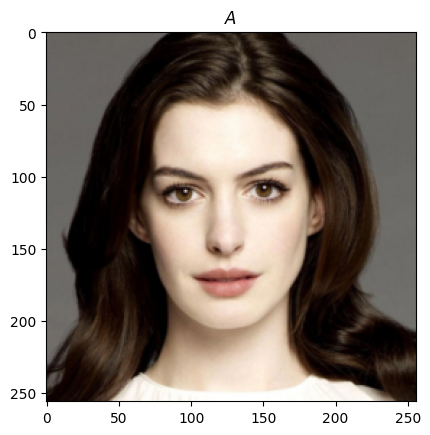

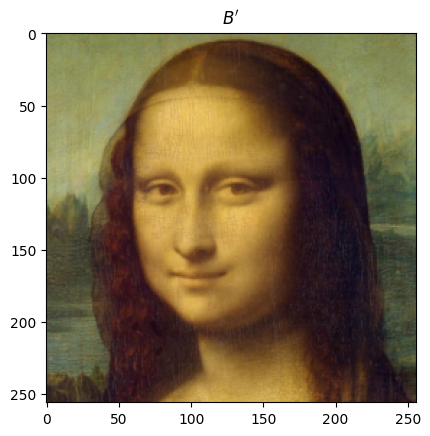

In [4]:
deprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(1/255)),
    transforms.Normalize(
        (0, 0, 0),
        (1.0 / VGG19_STD).tolist(),
    ),
    transforms.Normalize(
        (-VGG19_MEAN).tolist(),
        (1, 1, 1),
    ),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.ToPILImage(),
])

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image[0])
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(A, title='$A$')

plt.figure()
imshow(B_, title="$B'$")

## Step 2: Preprocess

First, we need to get the feature maps.

In [5]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = cnn(x)
    return feats

We only need five layers.

In [6]:
layers = ['r11', 'r21', 'r31', 'r41', 'r51']
feats_A = {k: v for k, v in get_feature_maps(A, cnn).items() if k in layers}
feats_B_ = {k: v for k, v in get_feature_maps(B_, cnn).items() if k in layers}

Initialize $F_{A'}^5$ and $F_B^5$ with $F_A^5$ $F_{B'}^5$ respectively (i.e. assume they are the same in the deepest layer).

In [7]:
feats_A_ = dict()
feats_B = dict()

feats_A_['r51'] = feats_A['r51']
feats_B['r51'] = feats_B_['r51']

## Step 3: Nearest-neighbor Field Search

Identify a mapping function

$$
\phi^L_{a\rightarrow b}(p)=\argmin\limits_q \sum\limits_{x\in N(p),y\in N(q)}(||\bar{F}_A^L(x)-\bar{F}_B^L(y)||^2+||\bar{F}_{A'}^L(x)-\bar{F}_{B}'^L(y)||^2),
$$
where $N(p)$ is a patch around $p$, and $\bar{F}^L(x)=\frac{{F}^L(x)}{|{F}^L(x)|}$.

One idea is that $\phi^L_{a\rightarrow b}$ is constrained by $\phi^{L+1}_{b\rightarrow a}$ through $F_B^L$.

First, assume we have known the feature maps of one specific layer, we need to implement the function to find out the mapping relationship.

In [8]:
def normalize(feat):
    return feat / torch.norm(feat)


def get_patches(img, patch_size):
    """
    Get the patches of an image.
    
    Inputs:
    - img: A tensor of shape (B, C, H, W)
    - patch_size: The size of the patches
    - stride: The stride used to extract the patches
    
    Returns:
    - patches: A tensor of shape (B, C, H, W, patch_size, patch_size)
    """
    patches = img.unfold(2, patch_size, 1).unfold(3, patch_size, 1)
    return patches

def match_patches(A, B, A_, B_, patch_size=5):
    """
    Match the patches of A with the patches of B.

    Returns:
    - matches: A tensor of shape (N, H, W, 2) 
    where matches[0, i, j] = [a, b] means that 
    the patch at (i, j) in A matches with the patch at (a, b) in B.
    """
    # the loss is (squared error between A and B) + (A_ and B_)
    A_patches = get_patches(normalize(A), patch_size)
    B_patches = get_patches(normalize(B), patch_size)
    A_patches_ = get_patches(normalize(A_), patch_size)
    B_patches_ = get_patches(normalize(B_), patch_size)
    N, C, H, W, _, _ = A_patches.shape
    # get a dist matrix of shape (N, H, W, H, W)
    dist = torch.zeros(N, H, W, H, W)
    for i in range(H):
        for j in range(W):
            dist[:, i, j] = torch.sum((B_patches[:, :, i, j].unsqueeze(2).unsqueeze(2) - A_patches)**2, dim=(1, 4, 5))
            + torch.sum((B_patches_[:, :, i, j].unsqueeze(2).unsqueeze(2) - A_patches_)**2, dim=(1, 4, 5))
    indices = torch.argmin(dist.view(N, H, W, -1), dim=3)
    matches = torch.stack([indices // W, indices % W], dim=3)
    return matches

After these implementation, we can match Layer 5 first to verify our implementation.

In [9]:
patch_sizes = {'r11': 5, 'r21': 5, 'r31': 3, 'r41': 3, 'r51': 3}
matches = match_patches(
    feats_A['r51'], feats_B['r51'], feats_A_['r51'], feats_B_['r51'], 
    patch_size=patch_sizes['r51']
)
print(matches.shape)

torch.Size([1, 14, 14, 2])


Let's visualize the distance between feature maps before proceeding.

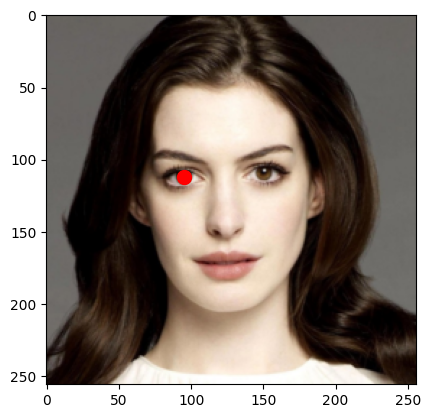

In [10]:
# get the eye of anni
anni = image_loader("./Images/anni.jpg", imsize)
location = (95, 112)
plt.figure()
plt.imshow(deprocess(A[0]))
plt.scatter(*location, color='red', s=100)
plt.show()

(6, 5)
torch.Size([1, 512, 14, 14, 3, 3])
torch.Size([1, 512, 1, 1, 3, 3])
torch.Size([14, 14])


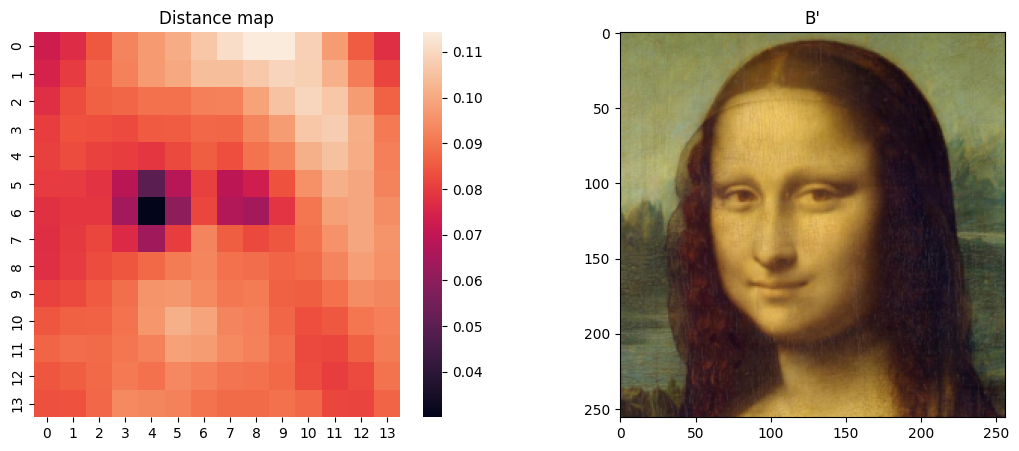

In [11]:
# find corresponding patch
patch = (location[1] // 18, location[0] // 18)
print(patch)

A_patches = get_patches(normalize(feats_A['r51']), 3)
B_patches_ = get_patches(normalize(feats_B_['r51']), 3)
print(B_patches_.shape)

one_patch = A_patches[:, :, patch[0], patch[1]].unsqueeze(2).unsqueeze(2)
print(one_patch.shape)

# get dist map
dist = torch.sum((one_patch - B_patches_)**2, dim=(1, 4, 5)).squeeze(0)
print(dist.shape)

import seaborn as sns
plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.heatmap(dist.cpu().numpy())
plt.title("Distance map")
plt.subplot(122)
plt.imshow(deprocess(B_[0]))
plt.title("B'")
plt.show()

We can see that the eye of anni matches the eye of mona.

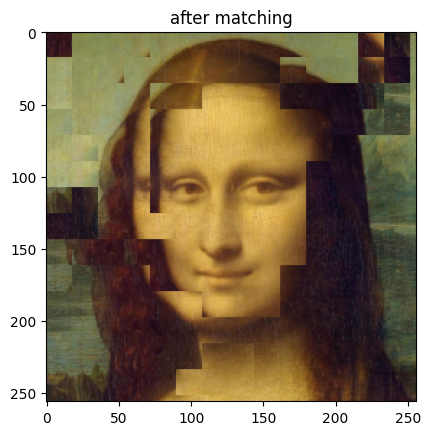

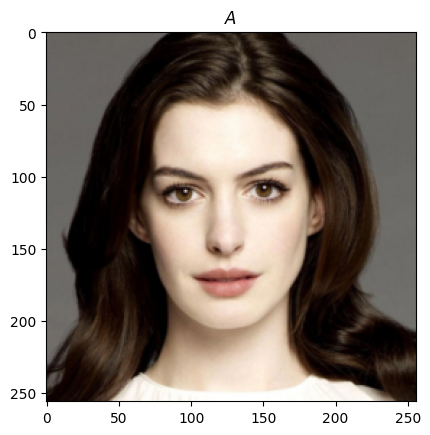

In [12]:
# visualize the matches
def visualize_matches(A, B, matches):
    """
    Visualize the matches between A and B.
    
    Inputs:
    - A: A tensor of shape (B, C, H, W)
    - matches: A tensor of shape (N, H, W, 2)
    """
    A = np.array(deprocess(A[0]))
    B = np.array(deprocess(B[0]))
    B_after = np.copy(B)
    H, W, _ = B.shape
    Hf = matches.shape[1]
    Wf = matches.shape[2]
    patch_H = H // Hf
    patch_W = W // Wf
    for i in range(Hf):
        for j in range(Wf):
            a, b = matches[0, i, j]
            x_after = a*patch_H
            y_after = b*patch_W
            x = i*patch_H
            y = j*patch_W
            B_after[x_after:x_after+patch_H, y_after:y_after+patch_W] = B[x:x+patch_H, y:y+patch_W]
    plt.figure()
    plt.imshow((B_after))
    plt.title("after matching")
    plt.show()

visualize_matches(A, B_, matches)
plt.figure()
imshow(A, title="$A$")
plt.show()

It can be seen that the coarse semantic features are well matched.

# **You can ignore contents below!!!**

## Step 4: Latent Image Reconstruction

The next step is to get $F_{A'}^4$ and $F_{B}^4$ and feature maps of even lower layers.

First, we need to wrap $F_{B'}^5$.

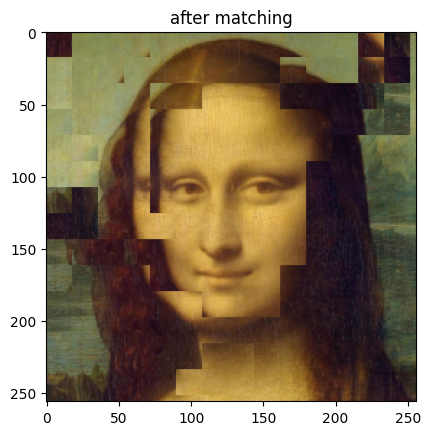

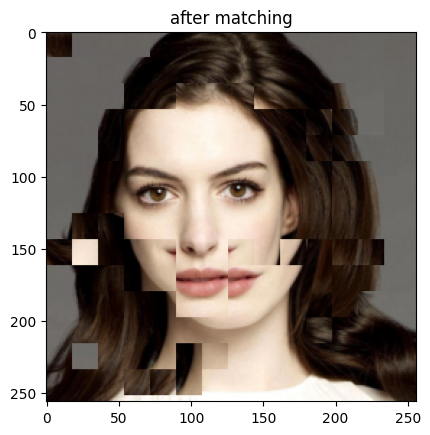

In [13]:
def wrap_feature_map(feat, matches):
    """
    Wrap the feature map using the matches.
    
    Inputs:
    - feat: A tensor of shape (B, C, H, W)
    - matches: A tensor of shape (N, H, W, 2)
    
    Returns:
    - wrapped: A tensor of shape (B, C, H, W)
    """
    N, H, W, _ = matches.shape
    wrapped = torch.zeros_like(feat)
    for i in range(H):
        for j in range(W):
            a, b = matches[0, i, j]
            wrapped[:, :, a, b] = feat[:, :, i, j]
    return wrapped


matches5_b2a = match_patches(
    feats_A['r51'], feats_B['r51'], feats_A_['r51'], feats_B_['r51'], 
    patch_size=3
    )
matches5_a2b = match_patches(
    feats_B['r51'], feats_A['r51'], feats_B_['r51'], feats_A_['r51'], 
    patch_size=3
    )
visualize_matches(A, B_, matches5_b2a)
visualize_matches(B_, A, matches5_a2b)
F_b2a = wrap_feature_map(feats_B_['r51'], matches5_b2a)
F_a2b = wrap_feature_map(feats_A['r51'], matches5_a2b)

Use optimization to get $R_{B'}^4$.

In [14]:
def deconv(r, f, cnn, start, end, iter=100, showevery=10):
    """
    Inputs:
    - r: The feature map to be optimized
    - f: The feature map to match
    - cnn: The VGG model
    - start: The layer to start from, e.g. 3
    - end: The layer to end at, e.g. 'r51'

    Returns:
    - r: The optimized feature map
    """
    optimizer = optim.LBFGS([r])
    for i in range(iter):
        def closure():
            optimizer.zero_grad()
            cnn_r = cnn(r, start=start)[end]
            loss = F.mse_loss(cnn_r, f, reduction='sum')
            loss.backward()
            return loss
        optimizer.step(closure)
        if (i+1) % showevery == 0:
            print(f"Iteration {i+1}: Loss {closure().item()}")
    return r.detach()


r4_B_ = torch.randn_like(feats_B_['r41'], requires_grad=True)
r4_A = torch.randn_like(feats_A['r41'], requires_grad=True)
r4_B_ = deconv(r4_B_, F_b2a, cnn, start=3, end='r51', iter=30)
r4_A = deconv(r4_A, F_a2b, cnn, start=3, end='r51', iter=30)
print(r4_B_.shape, r4_A.shape)

Iteration 10: Loss 49826436.0
Iteration 20: Loss 37058784.0
Iteration 30: Loss 33150688.0
Iteration 10: Loss 102834928.0
Iteration 20: Loss 78865616.0
Iteration 30: Loss 71265536.0
torch.Size([1, 512, 32, 32]) torch.Size([1, 512, 32, 32])


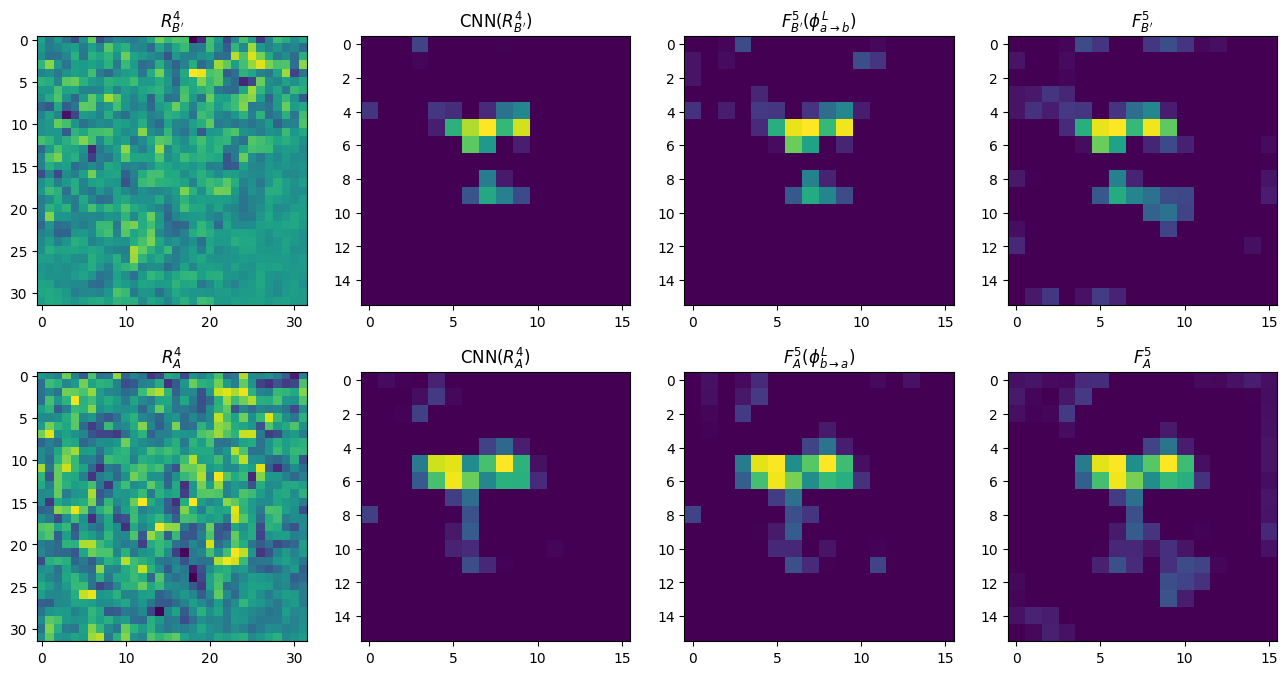

In [15]:
# visualize the deconvolved feature maps
plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.imshow(r4_B_[0, 0].cpu().numpy())
plt.title("$R^{4}_{B'}$")
plt.subplot(242)
plt.imshow(cnn(r4_B_, start=3)['r51'][0, 0].cpu().detach().numpy())
plt.title("$\\text{CNN}(R^{4}_{B'})$")
plt.subplot(243)
plt.imshow(F_b2a[0, 0].cpu().numpy())
plt.title("$F^{5}_{B'}(\phi^L_{a \\rightarrow b})$")
plt.subplot(244)
plt.imshow(feats_B_['r51'][0, 0].cpu().numpy())
plt.title("$F^{5}_{B'}$")
plt.subplot(245)
plt.imshow(r4_A[0, 0].cpu().numpy())
plt.title("$R^{4}_{A}$")
plt.subplot(246)
plt.imshow(cnn(r4_A, start=3)['r51'][0, 0].cpu().detach().numpy())
plt.title("$\\text{CNN}(R^{4}_{A})$")
plt.subplot(247)
plt.imshow(F_a2b[0, 0].cpu().numpy())
plt.title("$F^{5}_{A}(\phi^L_{b \\rightarrow a})$")
plt.subplot(248)
plt.imshow(feats_A['r51'][0, 0].cpu().numpy())
plt.title("$F^{5}_{A}$")
plt.show()


For NNF search in lower layers, we use higher layer matches as a guidance.

In [16]:
def match_patches(A, B, A_, B_, guidances=None, patch_size=5):
    """
    Match the patches of A with the patches of B.

    Returns:
    - matches: A tensor of shape (N, H, W, 2) 
    where matches[0, i, j] = [a, b] means that 
    the patch at (i, j) in A matches with the patch at (a, b) in B.
    """
    # the loss is (squared error between A and B) + (A_ and B_)
    A_patches = get_patches(normalize(A), patch_size)
    B_patches = get_patches(normalize(B), patch_size)
    A_patches_ = get_patches(normalize(A_), patch_size)
    B_patches_ = get_patches(normalize(B_), patch_size)
    N, C, H, W, _, _ = A_patches.shape
    # get a dist matrix of shape (N, H, W, H, W)
    dist = torch.zeros(N, H, W, H, W)
    for i in range(H):
        for j in range(W):
            dist[:, i, j] = torch.sum((B_patches[:, :, i, j].unsqueeze(2).unsqueeze(2) - A_patches)**2, dim=(1, 4, 5))
            + torch.sum((B_patches_[:, :, i, j].unsqueeze(2).unsqueeze(2) - A_patches_)**2, dim=(1, 4, 5))
    # if we have a guidance, confine the search space to an area around the guidance
    if guidances is not None:
        H_g = guidances.shape[1]
        W_g = guidances.shape[2]
        d_H = H / H_g
        d_W = W / W_g
        for i in range(H):
            for j in range(W):
                guidance = guidances[0, int(i/d_H - 1), int(j/d_W - 1)]
                a, b = guidance
                a, b = a*d_H, b*d_W
                dist[:, i, j, :int(a-4*d_H)] = float('inf')
                dist[:, i, j, int(a+4*d_H):] = float('inf')
                dist[:, i, j, :, :int(b-4*d_W)] = float('inf')
                dist[:, i, j, :, int(b+4*d_W):] = float('inf')

    indices = torch.argmin(dist.view(N, H, W, -1), dim=3)
    matches = torch.stack([indices // W, indices % W], dim=3)
    return matches

Then we can reconstruct lower layers iteratively.

In [17]:
def latent_reconstruction(img_A, img_B_, cnn):
    """
    Reconstruct the latent images.
    """
    layers = ['r11', 'r21', 'r31', 'r41', 'r51']
    patch_sizes = {'r11': 5, 'r21': 5, 'r31': 3, 'r41': 3, 'r51': 3}
    alphas = [0.8, 0.7, 0.6, 0.1]

    # get the feature maps
    feats_A = {k: v for k, v in get_feature_maps(img_A, cnn).items() if k in layers}
    feats_B_ = {k: v for k, v in get_feature_maps(img_B_, cnn).items() if k in layers}

    start = 3
    end = 4
    A_ = feats_A['r51']
    B = feats_B_['r51']
    guidance_b2a = None
    guidance_a2b = None
    while start >= 0:
        layer = layers[end]
        A, B_ = feats_A[layer], feats_B_[layer]
        f_A, f_B_ = feats_A[layers[start]], feats_B_[layers[start]]
        r_A = torch.randn_like(f_A, requires_grad=True)
        r_B_ = torch.randn_like(f_B_, requires_grad=True)
        
        # first, find matches
        matches_b2a = match_patches(A, B, A_, B_, guidances=guidance_b2a, patch_size=patch_sizes[layer])
        matches_a2b = match_patches(B, A, B_, A_, guidances=guidance_a2b, patch_size=patch_sizes[layer])
        guidance_b2a = matches_b2a
        guidance_a2b = matches_a2b

        # visualize
        visualize_matches(img_A, img_B_, matches_b2a)
        visualize_matches(img_B_, img_A, matches_a2b)
        
        # wrap the feature maps
        F_b2a = wrap_feature_map(B_, matches_b2a)
        F_a2b = wrap_feature_map(A, matches_a2b)

        # deconvolve
        r_A = deconv(r_A, F_a2b, cnn, start=start, end=layer, iter=10)
        r_B_ = deconv(r_B_, F_b2a, cnn, start=start, end=layer, iter=10)

        # calculate weights
        f_A_norm = (f_A - f_A.min()) / (f_A.max() - f_A.min())
        w_A = alphas[start] * 1 / (1 + torch.exp(-300 * f_A_norm**2 - 0.05))
        f_B__norm = (f_B_ - f_B_.min()) / (f_B_.max() - f_B_.min())
        w_B_ = alphas[start] * 1 / (1 + torch.exp(-300 * f_B__norm**2 - 0.05))

        # reconstruct
        A_ = w_A * f_A + (1 - w_A) * r_A
        B = w_B_ * f_B_ + (1 - w_B_) * r_B_
        
        start -= 1
        end -= 1
    
    matches_b2a = match_patches(feats_A['r11'], B, A_, feats_B_['r11'], patch_size=5)
    matches_a2b = match_patches(B, feats_A['r11'], feats_B_['r11'], A_, patch_size=5)
    return matches_b2a, matches_a2b

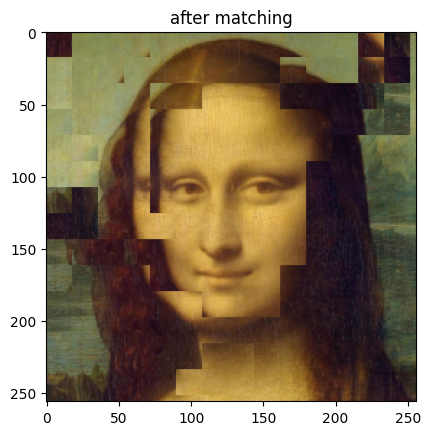

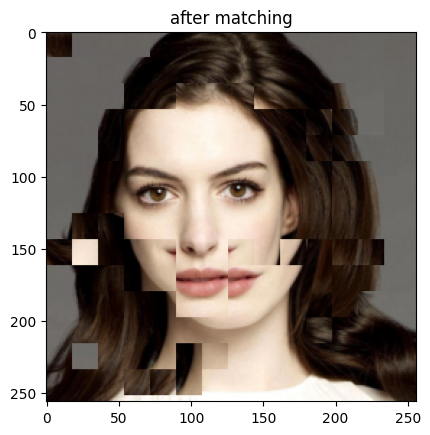

Iteration 10: Loss 108654744.0
Iteration 10: Loss 50398232.0


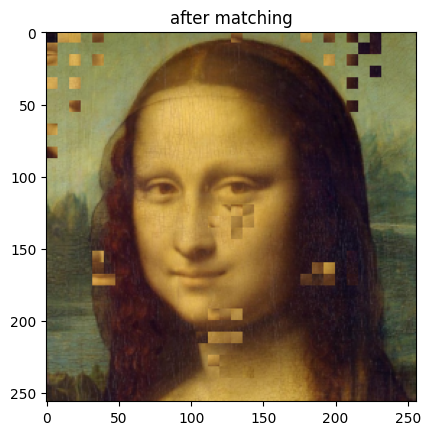

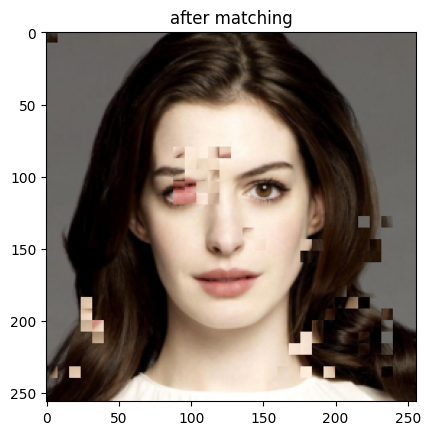

KeyboardInterrupt: 

In [18]:
A = image_loader("./Images/anni.jpg", imsize)
B_ = image_loader("./Images/mona.jpg", imsize)
matches_b2a, matches_a2b = latent_reconstruction(A, B_, cnn)

In [ ]:
visualize_matches(A, B_, matches_b2a, 256, 256)
visualize_matches(B_, A, matches_a2b, 256, 256)